### Modelling

In this section, we build a CNN model using AlexNet, VGG16 and ResNet50. AlexNet will be trained from scratch, whereas VGG16 and ResNet50 will be trained via transfer learning and imagenet weights are used while freezing all model layers.

In [28]:
import numpy as np 
import pandas as pd 
import os
import keras
import random
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix
import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.models import Model,Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from numpy import array, asarray
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [4]:
# define function for test accuracy

def model_accuracy(model):
    true_classes = test_generator.classes
    class_indices = train_generator.class_indices
    y_pred = model.predict(test_generator)
    y_pred_class = np.argmax(y_pred, axis=1)
    model_test_acc = accuracy_score(true_classes, y_pred_class)
    print("Test Accuracy: {:.2f}%".format(model_test_acc * 100))

In [5]:
# define function to plot confusion matrix
    
def con_matrix(model,test_generator):
    return confusion_matrix(test_generator.classes,np.argmax(model.predict(test_generator),axis=1))

In [6]:
# define function to plot train/validation accuracy and loss

def history_plots(history):
    history=pd.read_csv(history)
    fig,axes=plt.subplots(1,2,figsize=(16,6))

    train_loss = history['loss']
    test_loss = history['val_loss']
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    epoch_labels = history['epoch']

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')
    plt.title('Training and Testing Loss by Epoch', fontsize=18)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Categorical Crossentropy', fontsize=14)
    plt.xticks(epoch_labels, epoch_labels)   
    plt.legend(fontsize=16);


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Val accuracy')
    plt.title('Training and Testing Accuracy by Epoch', fontsize=18)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xticks(epoch_labels, epoch_labels)  
    plt.legend(fontsize=16);

All models were trained using Kaggle GPU, pls amend train_path, test_path and class_subset accordingly if you wish to run this notebook.

---
#### AlexNet

In [4]:
#AlexNet

train_path = '/kaggle/input/chart-images/images/train/'
test_path = '/kaggle/input/chart-images/images/test/'
class_subset = sorted(os.listdir('/kaggle/input/chart-images/images/train/'))
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   brightness_range=[0.6, 1.4],
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.25)
test_datagen = ImageDataGenerator(rescale = 1./255)
BATCH_SIZE= 64


train_generator = train_datagen.flow_from_directory(directory=train_path,
                                                    classes=class_subset,
                                                    target_size=(227,227),
                                                    batch_size=BATCH_SIZE,
                                                    subset='training',
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42)


validation_generator = train_datagen.flow_from_directory(directory=train_path,
                                                         classes=class_subset,
                                                         target_size=(227,227),
                                                         batch_size=BATCH_SIZE,
                                                         subset='validation',
                                                         class_mode='categorical',
                                                         shuffle=False,
                                                         seed=42)


test_generator = test_datagen.flow_from_directory(directory=test_path,
                                                  target_size=(227, 227),
                                                  classes=class_subset,
                                                  class_mode=None,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  seed=42)

anet_model = Sequential()
anet_model.add(Conv2D(filters=96, kernel_size=(11, 11),strides=(4, 4), activation="relu", input_shape=(227, 227, 3)))
anet_model.add(BatchNormalization())
anet_model.add(MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
anet_model.add(Conv2D(filters=256, kernel_size=(5, 5), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
anet_model.add(BatchNormalization())
anet_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
anet_model.add(Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
anet_model.add(BatchNormalization())
anet_model.add(Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
anet_model.add(BatchNormalization())
anet_model.add(Conv2D(filters=256, kernel_size=(3, 3),strides=(1, 1), activation="relu",padding="same"))
anet_model.add(BatchNormalization())
anet_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
anet_model.add(Flatten())
anet_model.add(Dense(4096, activation="relu",kernel_regularizer=l2(0.001)))
anet_model.add(Dropout(0.3))
anet_model.add(Dense(4096, activation="relu",kernel_regularizer=l2(0.001)))
anet_model.add(Dropout(0.3))
anet_model.add(Dense(3, activation="softmax"))
anet_model.summary()

anet_model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


n_steps = train_generator.samples // BATCH_SIZE
n_val_steps = validation_generator.samples // BATCH_SIZE
n_epochs = 50

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

checkpoint_path = '/kaggle/working/'+'anet_model.-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'
csv_logger = CSVLogger('/kaggle/working/anet_model_batch64.csv')
model_cp = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False,
                           monitor='val_loss', mode='auto', save_best_only=True, verbose=1)


anet_history = anet_model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validation_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[csv_logger,model_cp,early_stop],
                            verbose=1)

Found 4500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024   

1500/1500 [==============================] - 12s 8ms/step
Test Accuracy: 73.67%
1500/1500 [==============================] - 6s 4ms/step


array([[119, 371,  10],
       [  0, 499,   1],
       [  8,   5, 487]])

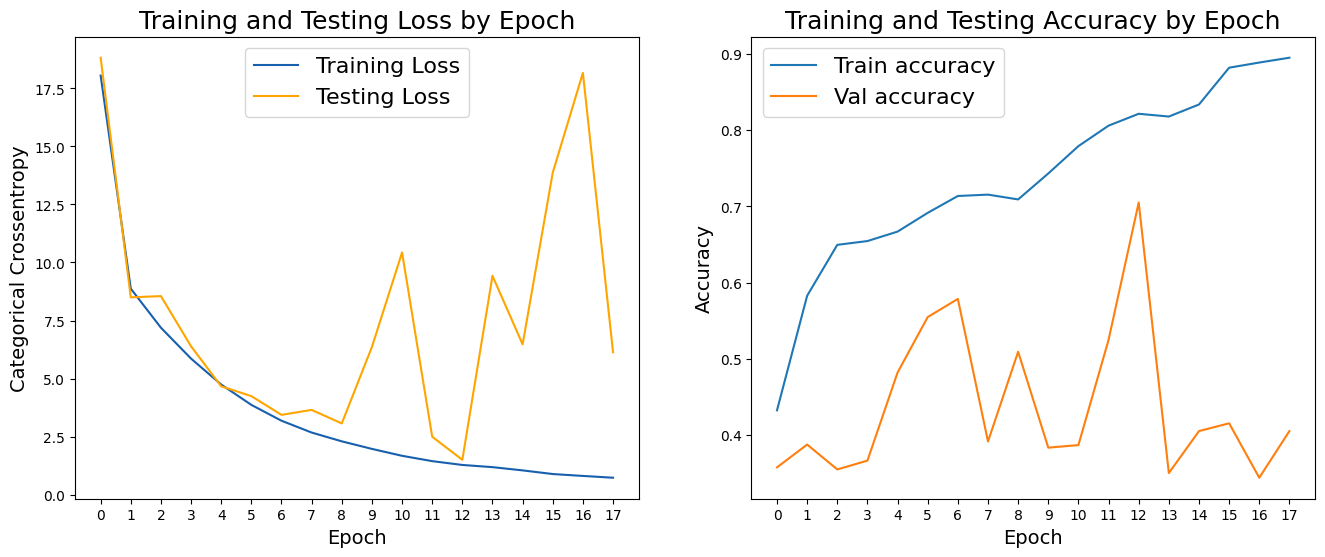

In [5]:
anet_model=keras.models.load_model('/kaggle/working/anet_model.-0.71-1.50.hdf5')
model_accuracy(anet_model)
history_plots(anet_history)
con_matrix(anet_model,test_generator)

---
#### ResNet 50

In [14]:
#resnet50

train_path = '/kaggle/input/chart-images/images/train/'
test_path = '/kaggle/input/chart-images/images/test/'
class_subset = sorted(os.listdir('/kaggle/input/chart-images/images/train/'))
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   brightness_range=[0.6, 1.4],
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.25)
test_datagen = ImageDataGenerator(rescale = 1./255)
BATCH_SIZE= 64

train_generator = train_datagen.flow_from_directory(directory=train_path,
                                                    classes=class_subset,
                                                    target_size=(224,224),
                                                    batch_size=BATCH_SIZE,
                                                    subset='training',
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42)


validation_generator = train_datagen.flow_from_directory(directory=train_path,
                                                         classes=class_subset,
                                                         target_size=(224,224),
                                                         batch_size=BATCH_SIZE,
                                                         subset='validation',
                                                         class_mode='categorical',
                                                         shuffle=False,
                                                         seed=42)


test_generator = test_datagen.flow_from_directory(directory=test_path,
                                                  target_size=(224, 224),
                                                  classes=class_subset,
                                                  class_mode=None,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  seed=42)


resnet50=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))

for layer in resnet50.layers:
    layer.trainable = False

x=AveragePooling2D(pool_size=(2, 2))(resnet50.output)
x=Flatten()(x)
prediction=Dense(3,activation='softmax')(x)
resnet50_model=Model(inputs=resnet50.input,outputs=prediction)

resnet50_model.summary()
resnet50_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

n_steps = train_generator.samples // BATCH_SIZE
n_val_steps = validation_generator.samples // BATCH_SIZE
n_epochs = 100

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
checkpoint_path = '/kaggle/working/resnet50_model.hdf5'
csv_logger = CSVLogger('/kaggle/working/resnet50_model_batch64.csv',append=True)
model_cp = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False,
                           monitor='val_loss', mode='auto', save_best_only=True, verbose=1)

resnet50_history = resnet50_model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validation_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[csv_logger,model_cp,early_stop],
                            verbose=1)

Found 4500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                  

1500/1500 [==============================] - 16s 10ms/step
Test Accuracy: 95.60%
1500/1500 [==============================] - 14s 10ms/step


array([[482,  12,   6],
       [ 10, 488,   2],
       [ 17,  19, 464]])

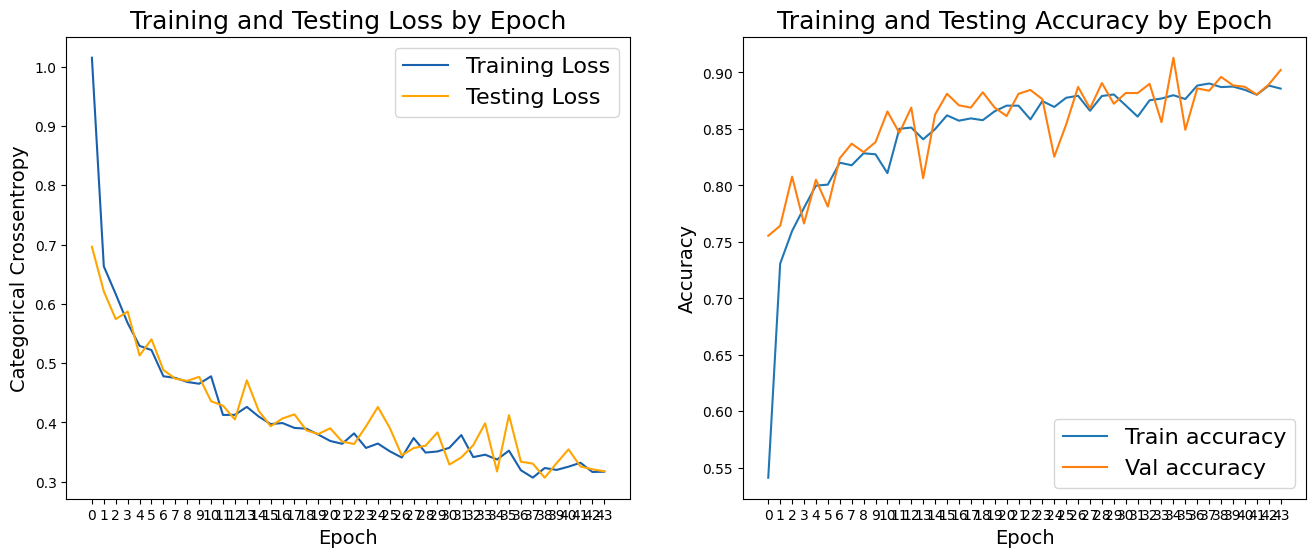

In [16]:
resnet50_model=keras.models.load_model('resnet50_model.hdf5')
model_accuracy(resnet50_model)
history_plots(resnet50_history)
con_matrix(resnet50_model,test_generator)

---
#### VGG16

In [27]:
#VGG16

train_path = '/kaggle/input/chart-images/images/train/'
test_path = '/kaggle/input/chart-images/images/test/'
class_subset = sorted(os.listdir('/kaggle/input/chart-images/images/train/'))
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   brightness_range=[0.6, 1.4],
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.25)
test_datagen = ImageDataGenerator(rescale = 1./255)
BATCH_SIZE= 64

train_generator = train_datagen.flow_from_directory(directory=train_path,
                                                    classes=class_subset,
                                                    target_size=(224,224),
                                                    batch_size=BATCH_SIZE,
                                                    subset='training',
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42)


validation_generator = train_datagen.flow_from_directory(directory=train_path,
                                                         classes=class_subset,
                                                         target_size=(224,224),
                                                         batch_size=BATCH_SIZE,
                                                         subset='validation',
                                                         class_mode='categorical',
                                                         shuffle=False,
                                                         seed=42)


test_generator = test_datagen.flow_from_directory(directory=test_path,
                                                  target_size=(224, 224),
                                                  classes=class_subset,
                                                  class_mode=None,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  seed=42)


vgg=VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

for layer in vgg.layers:
    layer.trainable = False

x=Flatten()(vgg.output)
x=Dense(4096, activation='relu')(x)
x=Dense(4096, activation='relu')(x)
prediction=Dense(3,activation='softmax')(x)
vgg16_model=Model(inputs=vgg.input,outputs=prediction)

vgg16_model.summary()
vgg16_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

n_steps = train_generator.samples // BATCH_SIZE
n_val_steps = validation_generator.samples // BATCH_SIZE
n_epochs = 100

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
checkpoint_path = '/kaggle/working/vgg16_model.hdf5'
csv_logger = CSVLogger('/kaggle/working/vgg16_model_batch64.csv',append=True)
model_cp = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False,
                           monitor='val_loss', mode='auto', save_best_only=True, verbose=1)

vgg16_history = vgg16_model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validation_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[csv_logger,model_cp,early_stop],
                            verbose=1)

Found 4500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    

In [22]:
vgg16_model=keras.models.load_model('/kaggle/input/vgg16-model/vgg16_model.hdf5')
vgg16_history=pd.read_csv('/kaggle/input/vgg16-history/vgg16_model_batch64.csv')

model_accuracy(vgg16_model)
con_matrix(vgg16_model,test_generator)

1500/1500 [==============================] - 10s 7ms/step
Test Accuracy: 99.47%
1500/1500 [==============================] - 10s 7ms/step


array([[497,   0,   3],
       [  3, 497,   0],
       [  2,   0, 498]])

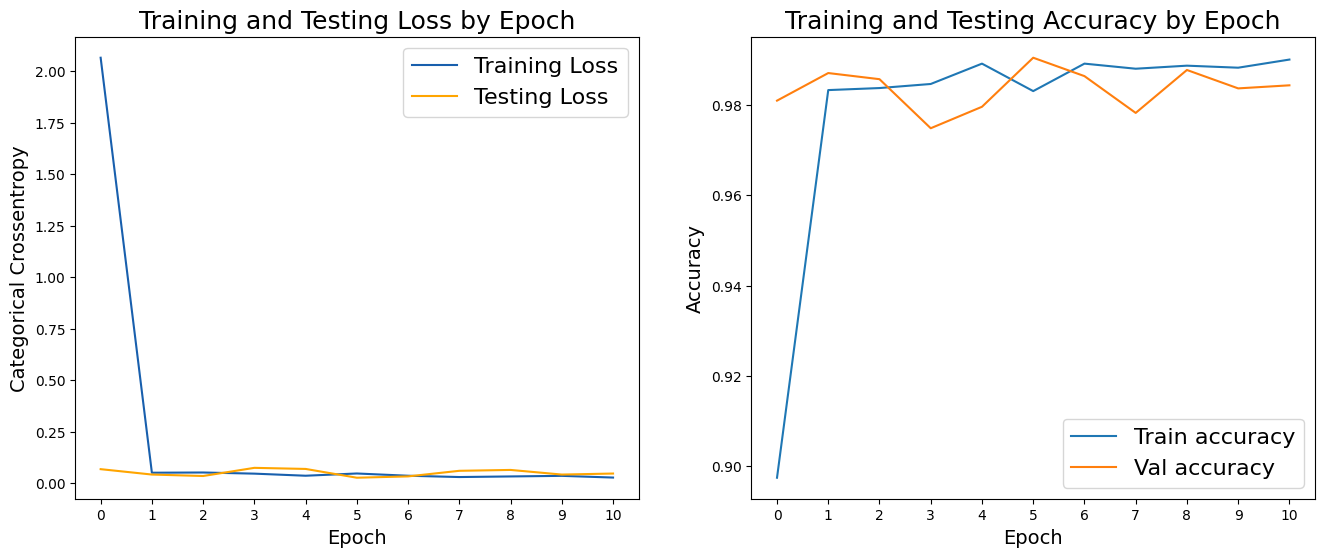

In [25]:
history=pd.read_csv('/kaggle/input/vgg16-history/vgg16_model_batch64.csv')
fig,axes=plt.subplots(1,2,figsize=(16,6))

train_loss = history['loss']
test_loss = history['val_loss']
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epoch_labels = history['epoch']

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Categorical Crossentropy', fontsize=14)
plt.xticks(epoch_labels, epoch_labels)   
plt.legend(fontsize=16);


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train accuracy')
plt.plot(val_accuracy, label='Val accuracy')
plt.title('Training and Testing Accuracy by Epoch', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(epoch_labels, epoch_labels)  
plt.legend(fontsize=16);

---

Another preliminary model was also built to examine if chart trend can be recognised. Train images were manually classified and 3 sample test images were used to check if the model was working fine.

In [34]:
train_path = './assets/chart trend/train/'
class_subset = sorted(os.listdir('./assets/chart trend/train/'))
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   brightness_range=[0.6, 1.4],
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.2)
BATCH_SIZE= 16

train_generator = train_datagen.flow_from_directory(directory=train_path,
                                                    classes=class_subset,
                                                    target_size=(224,224),
                                                    batch_size=BATCH_SIZE,
                                                    subset='training',
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42)


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, 
                                                            # height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

Found 240 images belonging to 3 classes.


({'decreasing': 0, 'increasing': 1, 'invariant': 2},
 array([[0.0021602 , 0.9891059 , 0.00873382]], dtype=float32))

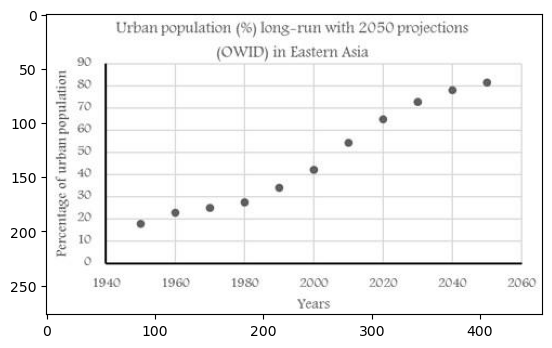

In [35]:
# checking for increasing trend
train_generator.reset()

model = load_model("./models/vgg16_trend_model.hdf5")
img_path = './assets/original images/e2fa786a6ff0.jpg'
   
# load a single image
new_image = load_image(img_path)

# check prediction
plt.imshow(asarray(Image.open(img_path)))
pred = model.predict(new_image)
train_generator.class_indices,pred


({'decreasing': 0, 'increasing': 1, 'invariant': 2},
 array([[0.04016925, 0.05962279, 0.900208  ]], dtype=float32))

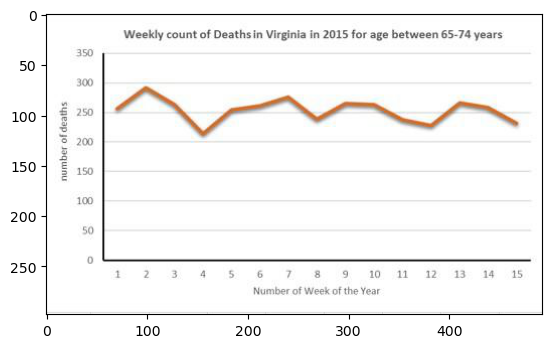

In [36]:
# checking for invariant trend
train_generator.reset()

model = load_model("./models/vgg16_trend_model.hdf5")
img_path = './assets/original images/90a196526808.jpg'
   
# load a single image
new_image = load_image(img_path)

# check prediction
plt.imshow(asarray(Image.open(img_path)))
pred = model.predict(new_image)
train_generator.class_indices,pred

({'decreasing': 0, 'increasing': 1, 'invariant': 2},
 array([[0.91463304, 0.04081934, 0.04454762]], dtype=float32))

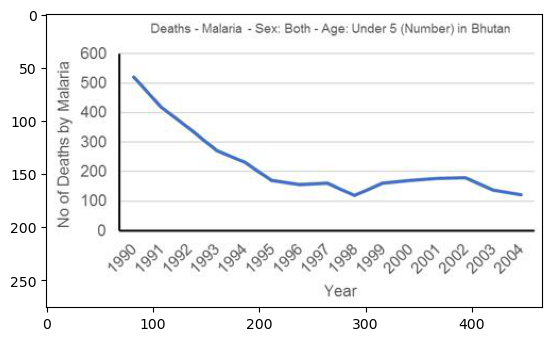

In [37]:
# checking for decreasing trend
train_generator.reset()

model = load_model("./models/vgg16_trend_model.hdf5")
img_path = './assets/original images/49296c956e4c.jpg'
   
# load a single image
new_image = load_image(img_path)

# check prediction
plt.imshow(asarray(Image.open(img_path)))
pred = model.predict(new_image)
train_generator.class_indices,pred

---
### Limitations

- Manually labelling chart trends can differ between individuals
- Chart trends may not be entirely conclusive
- Hard to extract text using Pytesseract or OpenCV

---
### Future Work

- Add further classification of different chart images (pie charts, area charts, Venn diagrams etc)
- To extract more features from plots (axis names/values, legend etc)
- To interpolate chart values using computer vision and use the numerical data for curve fitting to accurately predict trends
- Use of OCR to create captions for charts